In [ ]:
import pandas as pd

In [ ]:
# Opening the lidar data 

def open_lidar(filename, verbose=False):
    """Method for opening LiDAR text files and handling possible line errors
    """
    with open(filename, "r") as f:
        lines = f.readlines()

    new_lines = list()
    for line in lines:

        try:
            new_lines.append([float(val) for val in line.split()])

        except Exception as e:
            if verbose:
                print(line)

    new_lines = pd.DataFrame(new_lines)
    new_lines = new_lines.rename(columns={0: "x", 1: "y", 2: "z"})

    return new_lines

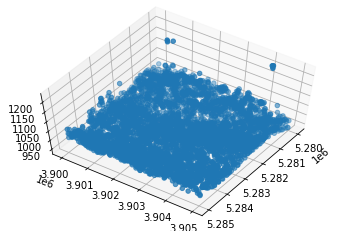

In [ ]:
# View sample of the lidar data 
# Must download N092E301.txt
from random import sample

data = open_lidar("N092E301.txt")

sample_data = data.sample(n=5000, random_state=1)


from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(sample_data["x"], sample_data["y"], sample_data["z"])
ax.view_init(60, 35)

In [ ]:
# Visualize and rotate the the data 

"""Title: How to automate LiDAR point cloud sub-samplong with python
Author: Florent Poux, Ph.D
Date: July 19, 2021
Availability: https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c """

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [ ]:
import plotly.graph_objects as go

In [ ]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='chartreuse')),
                      selector=dict(mode='markers'))
    fig.show()

In [ ]:
pcshow(sample_data["x"], sample_data["y"], sample_data["z"])

In [ ]:
# Placing the lidar data into a dataframe
full_data = pd.DataFrame({'X': data["x"], 'Y': data["y"], 'Z': data["z"]})
full_data

,X,Y,Z
0,5280001.36,3904999.68,942.85
1,5280003.49,3904999.18,999.29
2,5280006.56,3904999.77,998.73
3,5280004.77,3904999.22,985.39
4,5280005.16,3904998.99,964.97
...,...,...,...
5193268,5284965.43,3900001.15,1009.25
5193269,5284962.23,3900000.57,1009.20
5193270,5284967.88,3900000.49,1008.97
5193271,5284971.42,3900001.16,1010.88


In [ ]:
# Finding the maximum and minimum x values of the lidar data
x_max = full_data['X'].max()
print(x_max)
x_min = full_data['X'].min()
print(x_min)

# Finding the maximum and minimum y values of the lidar data
y_max = full_data['Y'].max()
print(y_max)
y_min = full_data['Y'].min()
print(y_min)

# Calculating the amount we should increment x and y by to create
# a complete and evenly space grid
x_increment = (x_max - x_min) / 1000
y_increment = (y_max - y_min) / 1000
print(f'x_increment: {x_increment}')
print(f'y_increment: {y_increment}')


5284999.99
5280000.0
3905000.0
3900000.01
x_increment: 4.999990000000223
y_increment: 4.999990000000223


In [ ]:
# creating an empty dataframe with 1000 rows and colmuns that with hold the 
# grouped lidar points
columns= [x for x in range(int(x_min), round(x_max), round(x_increment))]
index= [x for x in range(int(y_min), round(y_max), round(y_increment))]

empty_df = pd.DataFrame(data=np.zeros((1000, 1000)), columns= columns, index = index)

In [ ]:
full_data

,X,Y,Z
0,5280001.36,3904999.68,942.85
1,5280003.49,3904999.18,999.29
2,5280006.56,3904999.77,998.73
3,5280004.77,3904999.22,985.39
4,5280005.16,3904998.99,964.97
...,...,...,...
5193268,5284965.43,3900001.15,1009.25
5193269,5284962.23,3900000.57,1009.20
5193270,5284967.88,3900000.49,1008.97
5193271,5284971.42,3900001.16,1010.88


In [ ]:
# Find the group each x and y in the lidar data belongs to and increment the 
# value that group holds by 1
for x in range(full_data.shape[0]):
  x_dummy = full_data['X'].iloc[x]
  y_dummy = full_data['Y'].iloc[x]
  
  x_index = ((x_dummy - int(x_min)) / round(x_increment)) - 1
  y_index = ((y_dummy - int(y_min)) / round(y_increment)) - 1
  empty_df.iloc[int(y_index), int(x_index)] = empty_df.iloc[int(y_index), int(x_index)] + 1

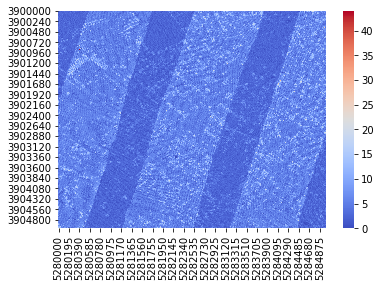

In [ ]:
# Heatmap of the distribution of LiDAR points

import seaborn as sns
ax = sns.heatmap(empty_df, cmap='coolwarm')
plt.show()

In [ ]:
# Viewing the shape of the dataframe
empty_df.shape

(1000, 1000)

In [ ]:
# View the dataframe
empty_df.tail(50)

,5280000,5280005,5280010,5280015,5280020,5280025,5280030,5280035,5280040,5280045,5280050,5280055,5280060,5280065,5280070,5280075,5280080,5280085,5280090,5280095,5280100,5280105,5280110,5280115,5280120,5280125,5280130,5280135,5280140,5280145,5280150,5280155,5280160,5280165,5280170,5280175,5280180,5280185,5280190,5280195,...,5284800,5284805,5284810,5284815,5284820,5284825,5284830,5284835,5284840,5284845,5284850,5284855,5284860,5284865,5284870,5284875,5284880,5284885,5284890,5284895,5284900,5284905,5284910,5284915,5284920,5284925,5284930,5284935,5284940,5284945,5284950,5284955,5284960,5284965,5284970,5284975,5284980,5284985,5284990,5284995
3904750,11.0,4.0,7.0,6.0,4.0,3.0,9.0,6.0,4.0,6.0,6.0,3.0,5.0,8.0,4.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,3.0,7.0,6.0,4.0,6.0,6.0,6.0,3.0,6.0,5.0,4.0,6.0,6.0,4.0,4.0,6.0,6.0,5.0,...,3.0,8.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,3.0,1.0,4.0,3.0,2.0,4.0,2.0,3.0,7.0,4.0,1.0,8.0,10.0,4.0,12.0,6.0,5.0,7.0,6.0,5.0,1.0,4.0,2.0,4.0,4.0,2.0,3.0,4.0,1.0,2.0,0.0
3904755,13.0,6.0,5.0,3.0,1.0,11.0,6.0,6.0,4.0,5.0,4.0,5.0,6.0,8.0,3.0,6.0,6.0,3.0,5.0,6.0,5.0,4.0,5.0,6.0,5.0,6.0,6.0,4.0,4.0,4.0,7.0,6.0,5.0,4.0,6.0,2.0,7.0,6.0,5.0,5.0,...,7.0,6.0,4.0,5.0,5.0,1.0,3.0,4.0,1.0,3.0,3.0,2.0,2.0,2.0,3.0,2.0,3.0,4.0,1.0,8.0,5.0,5.0,9.0,6.0,3.0,6.0,7.0,1.0,6.0,3.0,2.0,4.0,2.0,2.0,2.0,3.0,3.0,2.0,4.0,0.0
3904760,10.0,7.0,3.0,3.0,9.0,8.0,5.0,4.0,4.0,7.0,4.0,6.0,6.0,4.0,3.0,5.0,7.0,3.0,8.0,5.0,5.0,5.0,6.0,6.0,4.0,6.0,6.0,2.0,6.0,5.0,6.0,6.0,5.0,4.0,4.0,5.0,7.0,5.0,4.0,5.0,...,5.0,3.0,6.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,2.0,5.0,6.0,7.0,8.0,5.0,9.0,6.0,1.0,4.0,3.0,1.0,3.0,4.0,1.0,5.0,3.0,2.0,3.0,3.0,2.0,0.0
3904765,20.0,6.0,3.0,9.0,7.0,4.0,5.0,4.0,6.0,4.0,5.0,8.0,3.0,4.0,5.0,6.0,6.0,4.0,7.0,3.0,3.0,8.0,4.0,5.0,5.0,6.0,4.0,5.0,6.0,7.0,3.0,5.0,7.0,3.0,6.0,6.0,6.0,3.0,7.0,4.0,...,5.0,5.0,2.0,4.0,2.0,3.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,2.0,3.0,5.0,1.0,9.0,3.0,6.0,3.0,3.0,4.0,1.0,4.0,3.0,1.0,3.0,4.0,3.0,2.0,5.0,2.0,5.0,0.0
3904770,16.0,5.0,6.0,8.0,5.0,3.0,7.0,3.0,5.0,5.0,8.0,3.0,5.0,6.0,7.0,4.0,7.0,3.0,5.0,4.0,5.0,8.0,4.0,5.0,5.0,4.0,5.0,6.0,7.0,4.0,4.0,7.0,4.0,4.0,7.0,6.0,3.0,6.0,4.0,6.0,...,3.0,3.0,3.0,4.0,2.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,1.0,4.0,3.0,1.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,5.0,1.0,2.0,3.0,2.0,3.0,2.0,4.0,1.0,4.0,3.0,1.0,4.0,4.0,0.0
3904775,22.0,9.0,9.0,5.0,4.0,3.0,7.0,5.0,5.0,7.0,3.0,3.0,5.0,6.0,7.0,3.0,6.0,4.0,5.0,8.0,4.0,7.0,3.0,6.0,6.0,4.0,7.0,6.0,4.0,4.0,5.0,6.0,5.0,6.0,6.0,3.0,5.0,6.0,4.0,6.0,...,2.0,4.0,2.0,2.0,4.0,3.0,3.0,2.0,4.0,2.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,3.0,4.0,1.0,4.0,3.0,1.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,2.0,4.0,1.0,3.0,2.0,4.0,1.0,0.0
3904780,18.0,5.0,6.0,3.0,6.0,4.0,7.0,6.0,5.0,7.0,3.0,6.0,6.0,5.0,4.0,5.0,5.0,5.0,4.0,8.0,4.0,4.0,6.0,4.0,5.0,5.0,7.0,4.0,4.0,6.0,4.0,5.0,6.0,6.0,5.0,5.0,5.0,7.0,5.0,6.0,...,3.0,4.0,2.0,3.0,4.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,4.0,1.0,2.0,3.0,2.0,2.0,3.0,4.0,1.0,4.0,3.0,1.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,2.0,5.0,0.0
3904785,13.0,5.0,4.0,2.0,8.0,5.0,5.0,7.0,3.0,4.0,4.0,7.0,5.0,4.0,6.0,5.0,4.0,7.0,5.0,6.0,3.0,5.0,5.0,5.0,7.0,6.0,4.0,3.0,5.0,7.0,5.0,6.0,5.0,4.0,3.0,6.0,6.0,5.0,7.0,2.0,...,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0,2.0,5.0,7.0,2.0,7.0,4.0,3.0,5.0,3.0,2.0,2.0,4.0,1.0,2.0,4.0,1.0,3.0,2.0,4.0,2.0,4.0,6.0,1.0,4.0,2.0,2.0,4.0,2.0,2.0,0.0
3904790,13.0,4.0,4.0,6.0,7.0,5.0,3.0,6.0,3.0,6.0,6.0,6.0,5.0,6.0,4.0,6.0,3.0,8.0,4.0,4.0,3.0,6.0,7.0,4.0,6.0,5.0,4.0,5.0,7.0,6.0,3.0,6.0,6.0,2.0,7.0,6.0,5.0,9.0,2.0,3.0,...,3.0,3.0,3.0,1.0,4.0,3.0,1.0,5.0,3.0,3.0,4.0,5.0,5.0,4.0,5.0,2.0,7.0,4.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,1.0,2.0,4.0,1.0,3.0,3.0,3.0,2.0,3.0,3.0,1.0,4.0,0.0
3904795,9.0,5.0,6.0,7.0,5.0,3.0,6.0,7.0,3.0,7.0,7.0,2.0,5.0,4.0,7.0,3.0,7.0,6.0,3.0,4.0,8.0,4.0,5.0,4.0,7.0,2.0,5.0,7.0,5.0,4.0,5.0,6.0,3.0,6.0,7.0,6.0,9.0,2.0,3.0,4.0,...,4.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,4.0,5.0,3.0,9.0,7.0,4.0,8.0,5.0,6.0,5.0,3.0,1.0,3.0,3.0,1.0,4.0,3.0,2.0,4.0,2.0,2.0,4.0,4.0,1.0,2.0,4.0,1.0,3.0,3.0,3.0,0.0
